In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ssm, mu_qsm, var_ssm, var_qsm):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ssm-mu_qsm)
    ax2.hist(var_ssm-var_qsm)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

## Import `onefit` to get full GP version of SHO 

In [6]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [7]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# Kernel definition in `tinygp` and `ssmolgp`

In [8]:
import tinygp
import smolgp

In [9]:
## SHO Kernel
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
ssKernel = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
gpKernel = gpkernels.OscillationKernel()

Defaulting to solar values.


In [10]:
## Matern-5/2 Kernel
scale = 600. # sec
sigma = 5.3

qsKernel = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)
ssKernel = smolgp.kernels.Matern52(scale=scale, sigma=sigma)
gpKernel = gpkernels.Matern52Kernel()

In [11]:
%%timeit -n 100
qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

15.2 μs ± 1.17 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit -n 100
ssKernel =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

32.9 μs ± 3.21 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use tinygp to define a 'ground truth' process

In [13]:
# true_kernel = qsKernel

kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)
true_kernel = kernel1 + kernel2

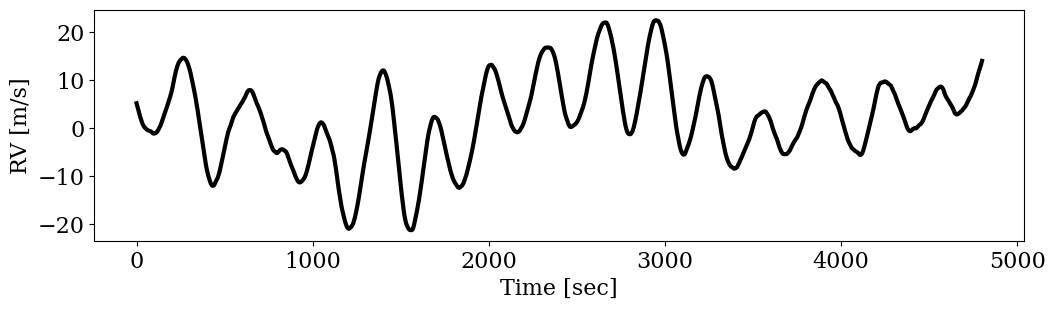

In [14]:
def get_true_qsm(tmin, tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(tmin, tmax, dt), tunit).to('s').value
    true_qsm = tinygp.GaussianProcess(true_kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_qsm.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_qsm(0, baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [15]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_qsm(0, baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N+2)[1:-1]
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [16]:
np.random.seed(231)

N = 30
yerr = 0.6 # m/s
t_train, y_train = generate_data(N, yerr)

i,di=10,5
delete = jnp.arange(i,i+di,1)
t_train = jnp.delete(t_train, delete)
y_train = jnp.delete(y_train, delete)

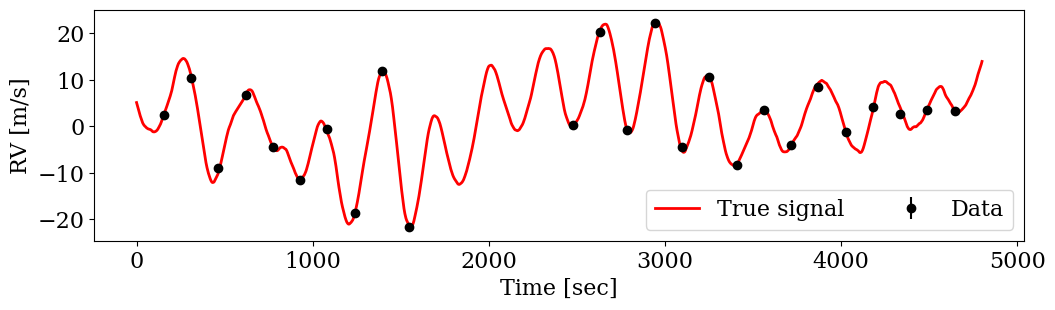

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [18]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsKernel, yerr=yerr)

In [19]:
t_test = jnp.linspace(t.min(), t.max(), 1000)

# Multi-component model

1. build with tinygp, build with smolgp

2. show they give the same likelihood

3. show they give the same conditioned/predictive mean/var

4. test mixture of integrated and regular kernel

In [20]:
# kernel1 = tinygp.kernels.quasisep.SHO(omega=0.0195, quality=7.63, sigma=1)
# kernel2 = tinygp.kernels.quasisep.Matern52(scale=600., sigma=1.)

# kernel = kernel1 + kernel2
# gp = tinygp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

In [21]:
# kernel1 = smolgp.kernels.SHO(omega=0.0195, quality=7.63, sigma=1)
# kernel2 = smolgp.kernels.Matern52(scale=600., sigma=1.)

# kernel = kernel1 + kernel2
# gp = smolgp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

## 1a. Build with `ssmolgp`

In [22]:
## SHO
ssm1 = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
# ssm2 = smolgp.kernels.SHO(omega=0.00234587265, 
#                            quality=1/jnp.sqrt(2), 
#                            sigma=0.329)
ssm2 = smolgp.kernels.Matern52(scale=scale, sigma=sigma)
ssm = ssm1 + ssm2
# ssm = ssm1 * ssm2
# ssm = ssm2 * ssm1
ssm

Sum(
  name='Sum(SHO, Matern52)',
  kernel1=SHO(name='SHO', omega=0.0195, quality=7.63, sigma=5.3, eta=weak_f64[]),
  kernel2=Matern52(name='Matern52', scale=600.0, sigma=5.3, lam=weak_f64[])
)

## 1b. Build with `tinygp`

In [23]:
kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
# kernel2 = tinygp.kernels.quasisep.SHO(omega=0.00234587265, 
#                                       quality=1/jnp.sqrt(2), 
#                                       sigma=0.329)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)

kernel = kernel1 + kernel2
# kernel = kernel1 * kernel2
# kernel = kernel2 * kernel1
kernel

Sum(
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=5.3),
  kernel2=Matern52(scale=600.0, sigma=5.3)
)

In [24]:
gp_ssm = smolgp.GaussianProcess(kernel=ssm, X=t_train, diag=yerr**2)
gp_qsm = tinygp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

## 2. Likelihoods verification

In [25]:
gp_qsm.log_probability(y_train)

Array(-85.67310821, dtype=float64)

In [26]:
gp_ssm.log_probability(y_train)

Array(-85.67310821, dtype=float64)

In [27]:
gp_qsm.log_probability(y_train) - gp_ssm.log_probability(y_train)

Array(0., dtype=float64)

## 3a. Condition verification

In [28]:
## Throws an error if X_test is not given (TODO: open issue in tinygp)
condGP_qsm = gp_qsm.condition(y_train, t_train).gp
llh, condGP_ssm = gp_ssm.condition(y_train)

# ## also going to have to do a check w/ to_dense in SSM predict
# condGP2.predict(t_test, return_var=True)

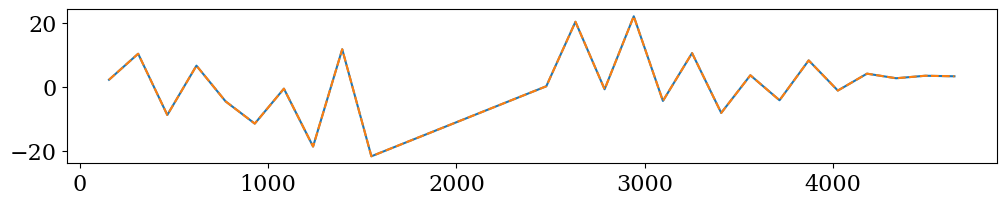

In [29]:
plt.figure(figsize=(12,2))
plt.plot(t_train, condGP_qsm.loc)
plt.plot(t_train, condGP_ssm.loc, ls='--')

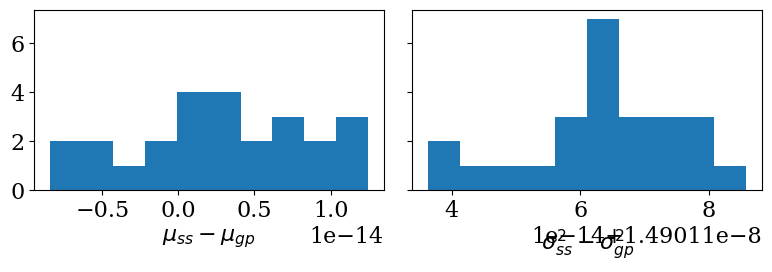

In [30]:
fig, (ax1, ax2) = histogram_residuals(condGP_qsm.loc, condGP_ssm.loc,
                                      condGP_qsm.variance, condGP_ssm.variance)

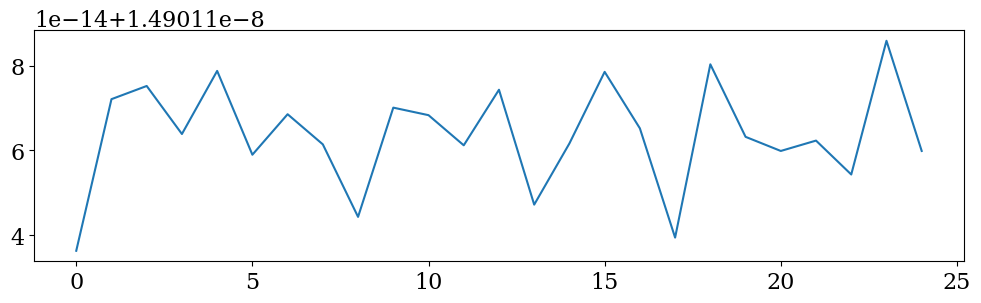

In [31]:
plt.figure(figsize=(12,3))
plt.plot(condGP_qsm.variance-condGP_ssm.variance)

In [32]:
# gp_qsm.predict(y_train) # throws an error if X_test is not given

# The problem is with this line, 
# something to do with `a` which comes from p, q, a = self.lower
# gp_qsm.solver.factor.inv()

## 3b. Prediction verification

In [33]:
mu_qsm, var_qsm = gp_qsm.predict(y_train, t_test, return_var=True)
std_qsm = jnp.sqrt(var_qsm)

In [34]:
mu_ssm, var_ssm = condGP_ssm.predict(t_test, return_var=True)
std_ssm = jnp.sqrt(var_ssm)
# mu_ssm, var_ssm = gp_ssm.predict(t_test, y_train, return_var=True)

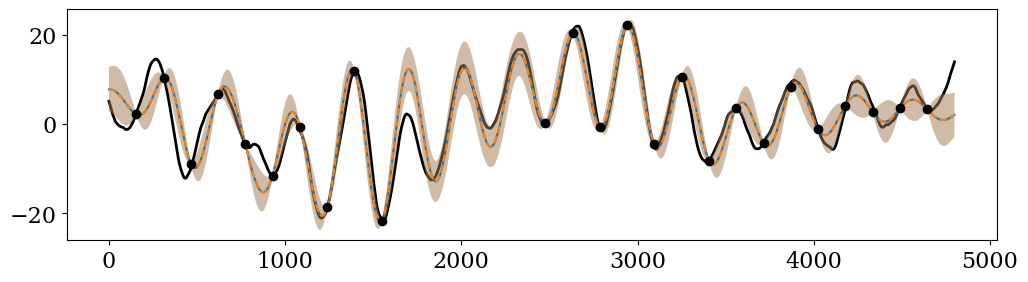

In [35]:
plt.figure(figsize=(12,3))

plt.plot(t, f(t), label='True signal', color='k', lw=2, zorder=-10)
plt.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data', alpha=1)

plt.plot(t_test, mu_qsm)
plt.fill_between(t_test, mu_qsm-jnp.sqrt(var_qsm), mu_qsm+jnp.sqrt(var_qsm), alpha=0.3)

plt.plot(t_test, mu_ssm, ls='--')
plt.fill_between(t_test, mu_ssm-jnp.sqrt(var_ssm), mu_ssm+jnp.sqrt(var_ssm), alpha=0.3)

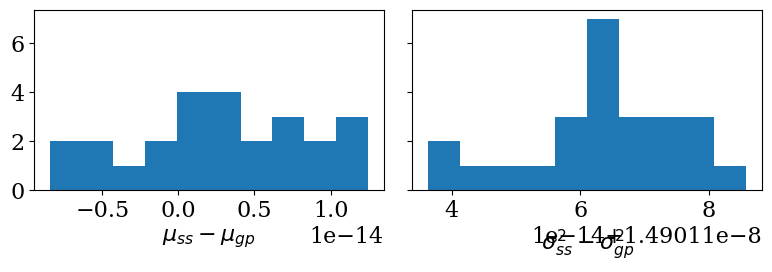

In [36]:
fig, (ax1, ax2) = histogram_residuals(condGP_qsm.loc, condGP_ssm.loc,
                                      condGP_qsm.variance, condGP_ssm.variance)

## Predict at a single component kernel

In [37]:
from smolgp.kernels import Sum, Product

In [38]:
from smolgp.kernels.base import extract_leaf_kernels
from smolgp.gp import assign_unique_kernel_names

In [39]:
testkernel = condGP_ssm.kernel#+ssm2*ssm

testkernel = assign_unique_kernel_names(testkernel)

kernels = extract_leaf_kernels(testkernel)
for k, kernel in enumerate(kernels):
    print(kernel.name)

SHO
Matern52


In [40]:
ys_ssm, yvars_ssm = condGP_ssm.component_means(return_var=True)
mus_ssm, vars_ssm = condGP_ssm.predict_component_means(t_test, return_var=True)

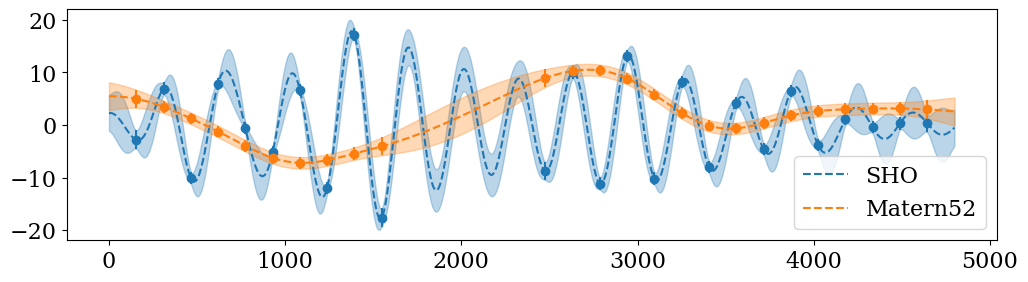

In [41]:
plt.figure(figsize=(12,3))
for k in range(len(ys_ssm)):
    plt.errorbar(t_train, ys_ssm[k], yerr=jnp.sqrt(yvars_ssm[k]), fmt='o', color=f'C{k}')

    plt.plot(t_test, mus_ssm[k], label=kernels[k].name, linestyle='--', color=f'C{k}')
    plt.fill_between(t_test,
                     mus_ssm[k]-jnp.sqrt(vars_ssm[k]),
                     mus_ssm[k]+jnp.sqrt(vars_ssm[k]), alpha=0.3, color=f'C{k}')

plt.legend();

In [42]:
# tinygp version of component means prediction
mus_qsm = []
vars_qsm = []
for k in gpkernels.extract_leaf_kernels(gp_qsm.kernel):
    yk, var_k = gp_qsm.predict(y_train, t_test, return_var=True, kernel=k)
    mus_qsm.append(yk)
    vars_qsm.append(var_k)

ys_qsm = []
yvars_qsm = []
for k in gpkernels.extract_leaf_kernels(gp_qsm.kernel):
    yk, var_k = gp_qsm.predict(y_train, t_train, return_var=True, kernel=k)
    ys_qsm.append(yk)
    yvars_qsm.append(var_k)

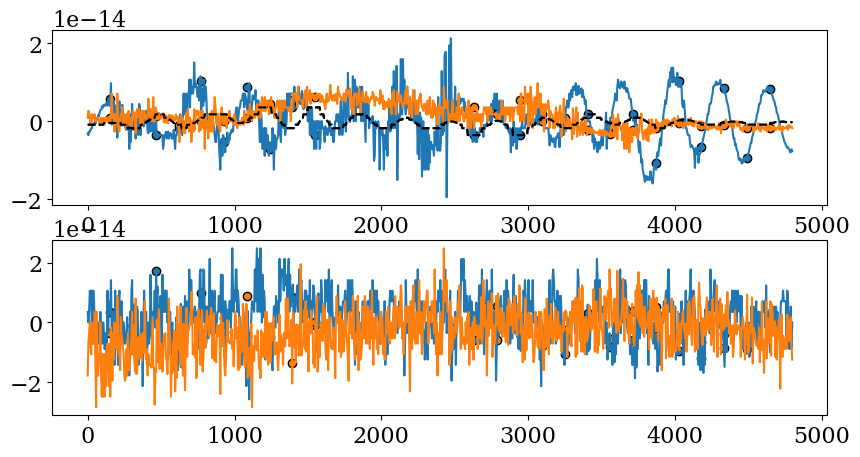

In [43]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 5))

eps = jnp.sqrt(jnp.finfo(jnp.array([0.])).eps)

for k in range(len(mus_ssm)):
    ax1.plot(t_test, mus_qsm[k]-mus_ssm[k])
    ax1.scatter(t_train, ys_qsm[k]-ys_ssm[k], ec='k')

    ax1.plot(t_test, -jnp.spacing(mu_ssm), color='k', ls='--')

    
    ax2.plot(t_test, vars_ssm[k] - vars_qsm[k] + eps)
    ax2.scatter(t_train, yvars_ssm[k] - yvars_qsm[k] + eps, ec='k')

In [44]:
condGP_ssm.kernel.name

'Sum(SHO, Matern52)'

In [45]:
condGP_ssm.kernel.observation_model(jnp.array([0]), component='SHO')

Array([[1, 0, 0, 0, 0]], dtype=int64)

In [46]:
## Conditioned mean/var 
y_ssm = condGP_ssm.loc
y_qsm = condGP_qsm.loc
yvar_ssm = condGP_ssm.variance
yvar_qsm = condGP_qsm.variance
yerr_ssm = jnp.sqrt(yvar_ssm)
yerr_qsm = jnp.sqrt(yvar_qsm)

std_qsm = jnp.sqrt(var_qsm)
std_ssm = jnp.sqrt(var_ssm)

# Plot

In [47]:
t_true = t
y_true = f(t)

In [48]:
mpl.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
mpl.rc("text", usetex=True)
mpl.rcParams["axes.formatter.useoffset"] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.markeredgecolor'] = 'k'
plt.rcParams['lines.linewidth'] = 2

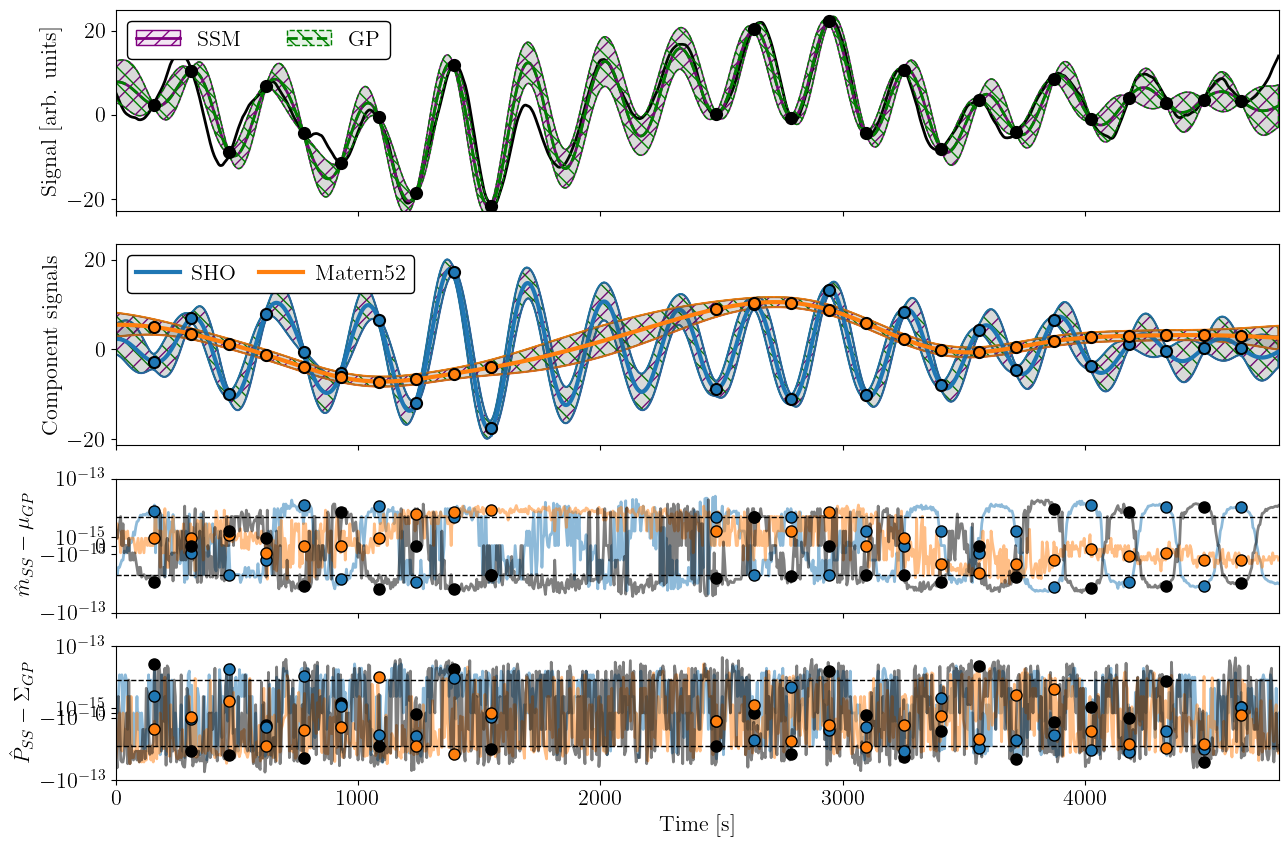

In [49]:
fig, (ax, ax2, rax, rrax) = plt.subplots(4,1, figsize=(15, 10), sharex=True, 
                                    gridspec_kw={'height_ratios':[1.5,1.5,1,1]})

cqsm = 'g'
cssm = 'purple'
rescolor = 'k'
epscolor = 'k'
s = 7

lines = []
labels = []
l1, = ax.plot(t_true, y_true, label='True signal', ls='-', color='k', lw=2)
l2 = ax.errorbar(t_train, y_train, yerr=yerr, c='k', fmt='o', zorder=100, label='Mock data')

### State space version
l, = ax.plot(t_test, mu_ssm, color=cssm, ls='-', zorder=2)
h1 = ax.fill_between(t_test, mu_ssm-std_ssm, mu_ssm+std_ssm, zorder=1, color=cssm, alpha=0.1)
h2 = ax.fill_between(t_test, mu_ssm-std_ssm, mu_ssm+std_ssm, zorder=1, hatch="//", facecolor='none', edgecolor=cssm, alpha=1)
l3 = (l,h1,h2)
labels.append("SSM")

### Full GP version
l, = ax.plot(t_test, mu_qsm, color=cqsm,   ls='--')
h1 = ax.fill_between(t_test, mu_qsm-std_qsm, mu_qsm+std_qsm, zorder=2, ls='--', color=cqsm, alpha=0.1)
h2 = ax.fill_between(t_test, mu_qsm-std_qsm, mu_qsm+std_qsm, zorder=2, ls='--', hatch="\\\\", facecolor='none', edgecolor=cqsm, alpha=1)
l4 = (l,h1,h2)
labels.append("GP")

### Decomposed components
for k in range(len(ys_ssm)):    
    ax2.fill_between(t_test, mus_ssm[k]-jnp.sqrt(vars_ssm[k]), mus_ssm[k]+jnp.sqrt(vars_ssm[k]), zorder=2, ls='-', color=cssm, alpha=0.1) # fill color for ssm
    ax2.fill_between(t_test, mus_qsm[k]-jnp.sqrt(vars_qsm[k]), mus_qsm[k]+jnp.sqrt(vars_qsm[k]), zorder=2, ls='--', color=cqsm, alpha=0.1) # fill color for qsm
    ax2.fill_between(t_test, mus_ssm[k]-jnp.sqrt(vars_ssm[k]), mus_ssm[k]+jnp.sqrt(vars_ssm[k]), hatch="//",   facecolor='none', edgecolor=cssm, alpha=1) # hatches for ssm
    ax2.fill_between(t_test, mus_qsm[k]-jnp.sqrt(vars_qsm[k]), mus_qsm[k]+jnp.sqrt(vars_qsm[k]), hatch="\\\\", facecolor='none', edgecolor=cqsm, alpha=1) # hatches for qsm
    ax2.fill_between(t_test, mus_qsm[k]-jnp.sqrt(vars_qsm[k]), mus_qsm[k]+jnp.sqrt(vars_qsm[k]), facecolor='none', lw=1.5, edgecolor=f'C{k}', alpha=1)  # borders blue/orange

    ax2.plot(t_test, mus_ssm[k], label=kernels[k].name, linestyle='-', color=f'C{k}', lw=3)
    # ax2.plot(t_test, mus_qsm[k], label=kernels[k].name, linestyle='-', color=f'C{k}')

    ax2.errorbar(t_train, ys_ssm[k], yerr=jnp.sqrt(yvars_ssm[k]), fmt='o', color=f'C{k}')


ax2.legend(loc='upper left', ncol=2, handletextpad=0.5, columnspacing=1, framealpha=1, edgecolor='k', )
ax2.set(ylim=[f(t).min(), f(t).max()+1])

offset = jnp.sqrt(jnp.finfo(jnp.array([0.])).eps)
for k in range(len(mus_ssm)):
    rax.plot(t_test, mus_qsm[k]-mus_ssm[k], alpha=0.5)
    rrax.plot(t_test, vars_ssm[k] - vars_qsm[k] + offset, alpha=0.5)
    rax.scatter(t_train, ys_qsm[k]-ys_ssm[k], ec='k', zorder=100)
    rrax.scatter(t_train, yvars_ssm[k] - yvars_qsm[k] + offset, ec='k', zorder=100)


### Residual axis 1: Means
rax.scatter(t_train, (y_ssm - y_qsm), color='k', zorder=100)
mu_res = mu_ssm - mu_qsm
rax.plot(t_test, mu_res, ls='-', color=rescolor, alpha=0.5, label=r'at $t_\ast$')

rax.set(ylabel=r'$\hat{m}_{SS}- \mu_{GP}$')
eps = np.abs(np.spacing(mu_ssm))
epsmax = eps.max()
rax.axhline(epsmax, color=epscolor, ls='--', lw=1)
rax.axhline(-epsmax, color=epscolor, ls='--', lw=1)
rax.set_yscale('symlog', linthresh=epsmax)
ylim = jnp.abs(mu_res).max() * 10
# rax.set_ylim(-ylim, ylim)
yticks = jnp.arange(-15, -12+1, 2).astype(jnp.float64)
yticks = jnp.hstack((-10**yticks[::-1], 0, 10**yticks))
rax.set_yticks(yticks)

### Residual axis 2: Variances
# offset = jnp.median(var_ssm-va.r_qsm); 
offset = -jnp.sqrt(jnp.finfo(jnp.array([0.])).eps) # from _default_diag
sign='$+$' if offset>=0 else '$-$'
var_res = var_ssm-var_qsm - offset
rrax.scatter(t_train, (yvar_ssm - yvar_qsm) - offset, color='k', zorder=10)
rrax.plot(t_test, var_res,    ls='-', color=rescolor, alpha=0.5, label=r'at $t_\ast$')

rrax.set(ylabel=r'$\hat{P}_{SS}- \Sigma_{GP}$')
# rrax.annotate(f'{sign}{np.abs(offset):.4e}', xy=(0, 1), xycoords='axes fraction', ha='left', va='bottom')
eps = np.abs(np.spacing(var_ssm))
epsmax = eps.max()
rrax.axhline(epsmax,  color=epscolor, ls='--', lw=1)
rrax.axhline(-epsmax, color=epscolor, ls='--', lw=1)
# rrax.plot(t_test, eps, color=epscolor, ls='--', lw=1)
rrax.set_yscale('symlog', linthresh=epsmax)
ylim = jnp.abs(var_res).max() * 10
# rrax.set_ylim(-ylim, ylim)

# yticks = [-1e-12, -1e-15, 0, 1e-15, 1e-12]
rrax.set_yticks(yticks)

#### Formatting
lines.extend([l3, l4])
ax.legend(lines, labels, ncol=2, framealpha=1, edgecolor='k', loc='upper left', #bbox_to_anchor=bbox_to_anchor
            # facecolor='#232323' 
            )
ax.set_ylim(f(t).min()-1.5, f(t).max()+2.5)
ax.set(ylabel='Signal [arb. units]', xlim=[t_test.min(), t_test.max()]);
ax2.set(ylabel='Component signals')
rrax.set(xlabel=f'Time [s]');
plt.savefig(f'/Users/rrubenzahl/Desktop/figures/ss_vs_qsm.png', dpi=300, bbox_inches='tight')

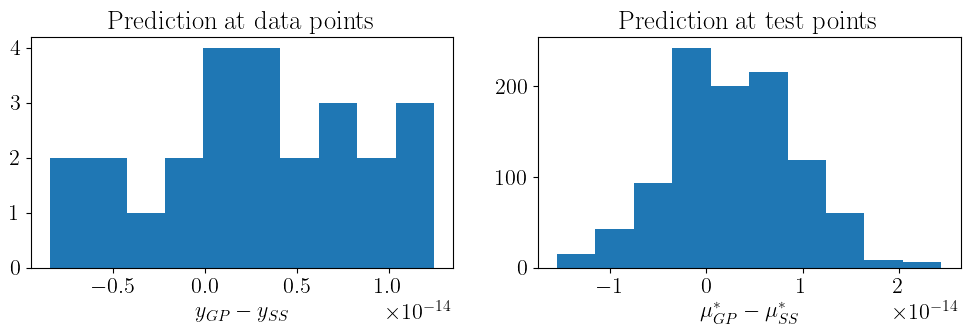

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_qsm - y_ssm);
# ax1.hist(yvar_qsm - yvar_ssm);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_qsm - mu_ssm);
# ax2.hist(var_qsm - var_ssm);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');